In [1]:
from utils import *
from envs import *
from model import *
import numpy as np
from copy import deepcopy
import argparse
import pandas as pd
import ast
parser = argparse.ArgumentParser()
parser.add_argument('--episodes', type=int, required=False, help='episodes', default=1)
parser.add_argument('--tmax', type=int, required=False, help='tmax', default=100)

parser.add_argument('--goalcoords', type=float,nargs='+', required=False, help='goalcoords', default=[0.5])
parser.add_argument('--rsz', type=float, required=False, help='rsz', default=0.05)
parser.add_argument('--rmax', type=int, required=False, help='rmax', default=5)

parser.add_argument('--seed', type=int, required=False, help='seed', default=2020)
parser.add_argument('--pcinit', type=str, required=False, help='pcinit', default='uni')
parser.add_argument('--npc', type=int, required=False, help='npc', default=32)
parser.add_argument('--alpha', type=float, required=False, help='alpha', default=1.0)
parser.add_argument('--sigma', type=float, required=False, help='sigma', default=0.05)

parser.add_argument('--plr', type=float, required=False, help='plr', default=0.01)
parser.add_argument('--clr', type=float, required=False, help='clr', default=0.01)
parser.add_argument('--llr', type=float, required=False, help='llr', default=0.000) 
parser.add_argument('--alr', type=float, required=False, help='alr', default=0.000) 
parser.add_argument('--slr', type=float, required=False, help='slr', default=0.000)
parser.add_argument('--gamma', type=float, required=False, help='gamma', default=0.9)
parser.add_argument('--nact', type=int, required=False, help='nact', default=2)

parser.add_argument('--balpha', type=float, required=False, help='balpha', default=0.0)
parser.add_argument('--paramsindex', type=int,nargs='+', required=False, help='paramsindex', default=[0,1,2])
parser.add_argument('--noise', type=float, required=False, help='noise', default=0.000)

parser.add_argument('--datadir', type=str, required=False, help='datadir', default='./data/')
parser.add_argument('--figdir', type=str, required=False, help='figdir', default='./fig/')
parser.add_argument('--csvname', type=str, required=False, help='csvname', default='results')
args, unknown = parser.parse_known_args()


# training params
train_episodes = args.episodes
tmax = args.tmax

# env pararms
envsize = 1
maxspeed = 0.1
goalsize = args.rsz
startcoord = [-0.75]
goalcoords = args.goalcoords
seed = args.seed
initvelocity = 0.0
max_reward = args.rmax

#agent params
npc = args.npc
sigma = args.sigma
alpha = args.alpha
nact = args.nact

# noise params
noise = args.noise
paramsindex = args.paramsindex
piname = ''.join(map(str, paramsindex))
pcinit = args.pcinit

actor_eta = args.plr
critic_eta = args.clr
pc_eta = args.llr
sigma_eta = args.slr
constant_eta = args.alr
etas = [pc_eta, sigma_eta,constant_eta, actor_eta,critic_eta]
gamma = args.gamma
balpha = args.balpha


Plotting for paramsindex: [0]
Filtered data for paramsindex=(0,), slr=0.0:
 Empty DataFrame
Columns: [noise, paramsindex, var_pv]
Index: []
No data found for paramsindex=(0,)

Plotting for paramsindex: [1]
Filtered data for paramsindex=(1,), slr=0.0:
 Empty DataFrame
Columns: [noise, paramsindex, var_pv]
Index: []
No data found for paramsindex=(1,)

Plotting for paramsindex: [2]
Filtered data for paramsindex=(2,), slr=0.0:
 Empty DataFrame
Columns: [noise, paramsindex, var_pv]
Index: []
No data found for paramsindex=(2,)

Plotting for paramsindex: [0, 1]
Filtered data for paramsindex=(0, 1), slr=0.0:
 Empty DataFrame
Columns: [noise, paramsindex, var_pv]
Index: []
No data found for paramsindex=(0, 1)

Plotting for paramsindex: [0, 2]
Filtered data for paramsindex=(0, 2), slr=0.0:
 Empty DataFrame
Columns: [noise, paramsindex, var_pv]
Index: []
No data found for paramsindex=(0, 2)

Plotting for paramsindex: [1, 2]
Filtered data for paramsindex=(1, 2), slr=0.0:
 Empty DataFrame
Columns:

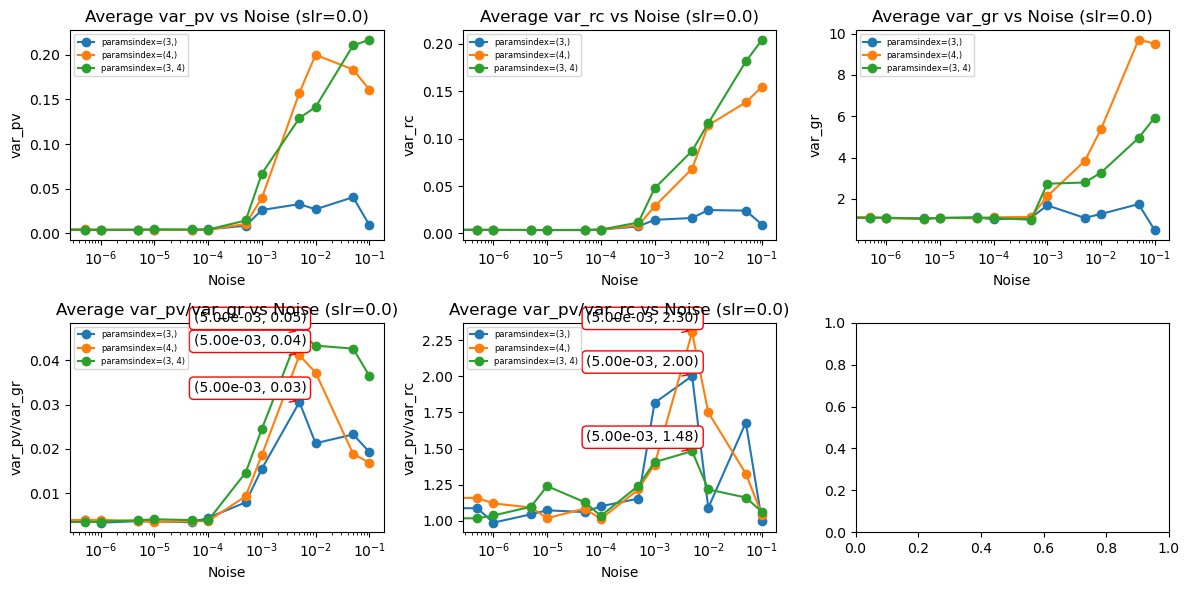

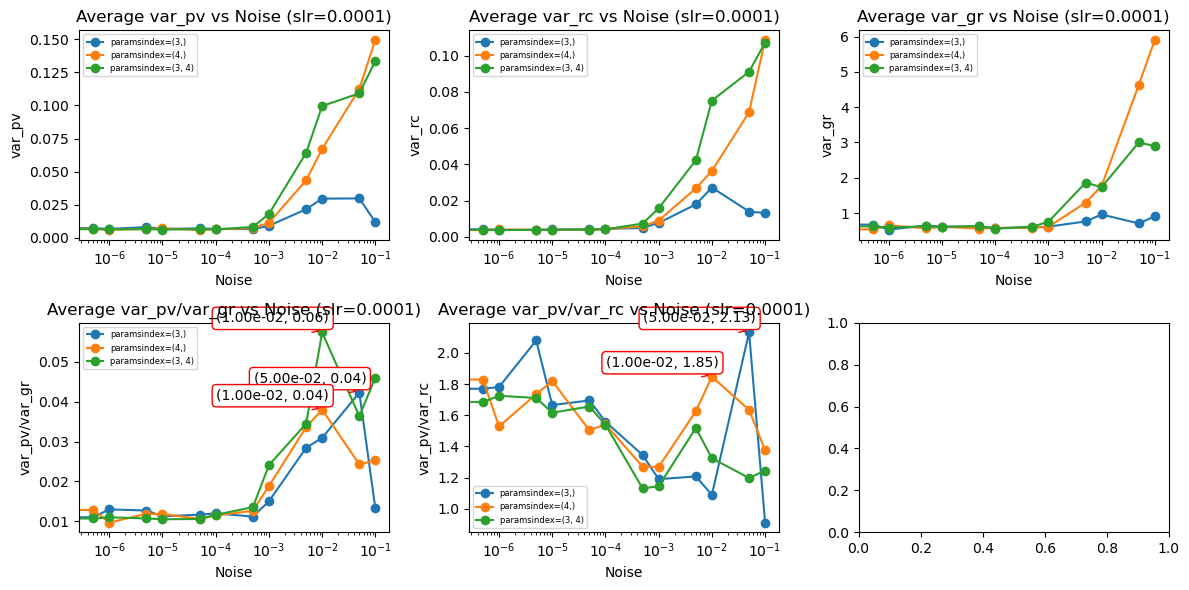

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure the CSV file is read correctly
df = pd.read_csv('./csvs/drift_results_noise.csv')

# Function to safely convert paramsindex to tuples
def safe_convert_paramsindex(x):
    if isinstance(x, str):
        return tuple(sorted(eval(x)))
    elif isinstance(x, list):
        return tuple(sorted(x))
    else:
        return x

# Convert the paramsindex column values to consistent, hashable types (sorted tuples)
df['paramsindex'] = df['paramsindex'].apply(safe_convert_paramsindex)

def plot_var_avg(dataframe, noise_vals, params_indices, slr_value, var_param1, var_param2=None, ax=None):
    if ax is None:
        # Create a figure and axis for plotting
        fig, ax = plt.subplots()

    # Filter dataframe for given slr_value
    filtered_df = dataframe[dataframe['slr'] == slr_value]
    
    # If only one variable is passed, calculate the mean of that variable
    if var_param2 is None:
        # Calculate mean for the specified variable grouped by noise and paramsindex
        mean_values = filtered_df[filtered_df['noise'].isin(noise_vals)].groupby(['noise', 'paramsindex'])[var_param1].mean().reset_index()
    else:
        # Calculate mean for both variables and compute the ratio
        mean_values = filtered_df[filtered_df['noise'].isin(noise_vals)].groupby(['noise', 'paramsindex']).agg({var_param1: 'mean', var_param2: 'mean'}).reset_index()
        mean_values['ratio'] = mean_values[var_param1] / mean_values[var_param2]
    
    for params_index in params_indices:
        print(f'\nPlotting for paramsindex: {params_index}')
        
        params_index = tuple(sorted(params_index))  # Ensure params_index is a sorted tuple for consistency
        
        filtered_data = mean_values[mean_values['paramsindex'] == params_index]
        
        # Check the filtered data
        print(f'Filtered data for paramsindex={params_index}, slr={slr_value}:\n', filtered_data)

        if not filtered_data.empty:
            filtered_data = filtered_data.sort_values(by='noise')
            if var_param2 is None:
                ax.plot(filtered_data['noise'], filtered_data[var_param1], label=f'paramsindex={params_index}', marker='o')
            else:
                ax.plot(filtered_data['noise'], filtered_data['ratio'], label=f'paramsindex={params_index}', marker='o')
                if not filtered_data['ratio'].empty:
                    max_idx = filtered_data['ratio'].idxmax()
                    max_x = filtered_data.loc[max_idx, 'noise']
                    max_y = filtered_data.loc[max_idx, 'ratio']
                    ax.annotate(f'({max_x:.2e}, {max_y:.2f})', xy=(max_x, max_y), xytext=(5, 5),
                                textcoords='offset points', ha='right', va='bottom',
                                bbox=dict(boxstyle='round,pad=0.3', edgecolor='red', facecolor='white'),
                                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color='red', lw=1,))
        else:
            print(f'No data found for paramsindex={params_index}')

    ax.set_xlabel('Noise')
    if var_param2 is None:
        ax.set_ylabel(var_param1)
        ax.set_title(f'Average {var_param1} vs Noise (slr={slr_value})')
    else:
        ax.set_ylabel(f'{var_param1}/{var_param2}')
        ax.set_title(f'Average {var_param1}/{var_param2} vs Noise (slr={slr_value})')
    
    ax.set_xscale('log')
    ax.legend(fontsize=6)

# Define noise values and params indices as required
noise_values = [0.0, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
params_indices = [[0],[1],[2],[0,1], [0,2],[1,2],[0,1,2], [3], [4], [3, 4]]

# Call the function with the slr value and one variable
f,ax = plt.subplots(2,3,figsize=(12,6))
plot_var_avg(df, noise_values, params_indices, 0.0, 'var_pv', ax=ax[0,0])
plot_var_avg(df, noise_values, params_indices, 0.0, 'var_rc', ax=ax[0,1])
plot_var_avg(df, noise_values, params_indices, 0.0, 'var_gr', ax=ax[0,2])

# Call the function with the slr value and two variables to plot the ratio
plot_var_avg(df, noise_values, params_indices, 0.0, 'var_pv', 'var_gr', ax=ax[1,0])
plot_var_avg(df, noise_values, params_indices, 0.0, 'var_pv', 'var_rc', ax=ax[1,1])
f.tight_layout()

f,ax = plt.subplots(2,3,figsize=(12,6))
plot_var_avg(df, noise_values, params_indices, 0.0001, 'var_pv', ax=ax[0,0])
plot_var_avg(df, noise_values, params_indices, 0.0001, 'var_rc', ax=ax[0,1])
plot_var_avg(df, noise_values, params_indices, 0.0001, 'var_gr', ax=ax[0,2])

# Call the function with the slr value and two variables to plot the ratio
plot_var_avg(df, noise_values, params_indices, 0.0001, 'var_pv', 'var_gr', ax=ax[1,0])
plot_var_avg(df, noise_values, params_indices, 0.0001, 'var_pv', 'var_rc', ax=ax[1,1])
f.tight_layout()

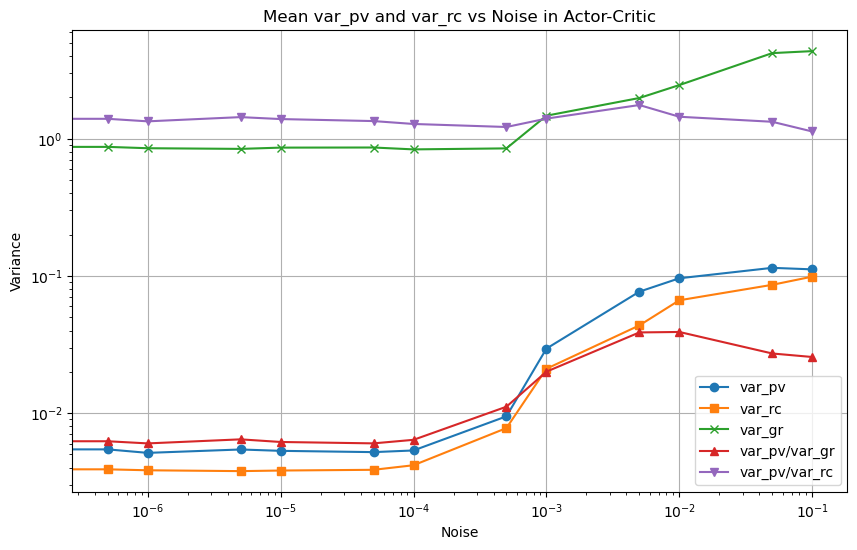

In [3]:
# drift vs noise
# var_pv, var_rc, var_gr
# Noise at actor critic

# Read the CSV file into a DataFrame
df = pd.read_csv('./csvs/drift_results_noise.csv')

# Define the noise values you are interested in
noise_values = [0.0, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

# Filtering the dataframe for the given noise values
filtered_df = df[df['noise'].isin(noise_values)]

# Group by noise and calculate mean of var_pv and var_rc
mean_values = filtered_df.groupby('noise')[['var_pv', 'var_rc', 'var_lat', 'var_gr']].mean().reset_index()

# Create line plots for var_pv and var_rc
plt.figure(figsize=(10, 6))

plt.plot(mean_values['noise'], mean_values['var_pv'], '-o', label='var_pv')
plt.plot(mean_values['noise'], mean_values['var_rc'], '-s', label='var_rc')
# plt.plot(mean_values['noise'], mean_values['var_lat'], '-^', label='var_lat')
plt.plot(mean_values['noise'], mean_values['var_gr'], '-x', label='var_gr')

plt.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_gr'], '-^', label='var_pv/var_gr')
plt.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_rc'], '-v', label='var_pv/var_rc')

# Configure plot
plt.xlabel('Noise')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean var_pv and var_rc vs Noise in Actor-Critic')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# drift vs noise
# var_pv, var_rc, var_gr
# Noise at pc

# Read the CSV file into a DataFrame
df = pd.read_csv('./csvs/drift_results_noise_pc.csv')

# Define the noise values you are interested in
noise_values = [0.0, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]

# Filtering the dataframe for the given noise values
filtered_df = df[df['noise'].isin(noise_values)]

# Group by noise and calculate mean of var_pv and var_rc
mean_values = filtered_df.groupby('noise')[['var_pv', 'var_rc', 'var_lat', 'var_gr']].mean().reset_index()

# Create line plots for var_pv and var_rc
plt.figure(figsize=(10, 6))

plt.plot(mean_values['noise'], mean_values['var_pv'], '-o', label='var_pv')
plt.plot(mean_values['noise'], mean_values['var_rc'], '-s', label='var_rc')
# plt.plot(mean_values['noise'], mean_values['var_lat'], '-^', label='var_lat')
plt.plot(mean_values['noise'], mean_values['var_gr'], '-x', label='var_gr')

plt.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_gr'], '-^', label='var_pv/var_gr')
plt.plot(mean_values['noise'], mean_values['var_pv']/mean_values['var_rc'], '-v', label='var_pv/var_rc')

# Configure plot
plt.xlabel('Noise')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')
plt.title('Mean var_pv and var_rc vs Noise in Fields')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [ ]:
# example PV corr & Rep Corr & G against trial

npc = 64
ns = 1e-3
pidx = '012'
slr = 0.0


seed = 0


exptname = f"./data/both_1D_td_online_0.0ba_{ns}ns_{pidx}p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_{slr}slr_uni_0.5a_0.05s_2a_{seed}s_50000e_5rmax_0.05rsz"



f,axs = plt.subplots(1,2,figsize=(6,3))

trials, pv_corr,rep_corr, startxcor, endxcor = get_pvcorr(logparams, stable_perf, total_trials, num=1001)

plot_rep_sim(startxcor, stable_perf, ax=axs[4,0])

plot_rep_sim(endxcor, total_trials, ax=axs[4,1])

drift = (np.std(pv_corr))/(np.std(np.array(latencys)[np.linspace(stable_perf, total_trials-1, num=1001, dtype=int)]))

plot_pv_rep_corr(trials, pv_corr, rep_corr,title=f"D={drift:.3f}",ax=axs[4,2])

param_delta = get_param_changes(logparams, total_trials)
plot_param_variance(param_delta, total_trials, stable_perf,axs=axs[5])

plot_l1norm(param_delta[2], ax=axs[5,2].twinx(), stable_perf=stable_perf)

plot_active_frac(logparams, total_trials, num=total_trials//1000, threshold=1.0,ax=axs[6,2])

plot_amplitude_drift(logparams, total_trials, stable_perf, ax=axs[1])


In [ ]:
# drift_i vs amplitude_i for example



def plot_amplitude_drift(logparams, total_trials, stable_perf, ax=None):
    if ax is None:
        f,ax = plt.subplots()
    param_delta = np.array(get_param_changes(logparams, total_trials, stable_perf))
    mean_amplitude = np.mean(param_delta[2]**2,axis=0)
    # delta_lambda = np.std(param_delta[0],axis=0)
    # delta_alpha = np.std(param_delta[2],axis=0)
    deltas = np.sum(np.std(param_delta,axis=1),axis=0)
    ax.scatter(mean_amplitude, deltas)
    if np.std(mean_amplitude) != 0:
        slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(mean_amplitude).reshape(-1), np.array(deltas).reshape(-1))
        regression_line = slope * np.array(mean_amplitude).reshape(-1) + intercept
        ax.plot(np.array(mean_amplitude).reshape(-1), regression_line, color='red', label=f'R:{np.round(r_value, 3)}, P:{np.round(p_value, 3)}')
    ax.legend(frameon=False)
    ax.set_xlabel('Mean Amplitude')
    ax.set_ylabel('$\sum var(\theta)$')


npc = 16
seed = 0
exptname = f"./data/both_1D_td_online_0.0ba_0.0ns_0p_{npc}n_0.01plr_0.01clr_0.0001llr_0.0001alr_0.0001slr_uni_0.5a_0.05s_2a_{seed}s_50000e_5rmax_0.05rsz"

